Embedding method: Treat each sentence separately

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import random
import nltk
import matplotlib.pyplot as plt
from scipy.linalg.interpolative import interp_decomp
from termcolor import colored
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-stsb-mean-tokens')

C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Savannah\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWa

# Load survey data

In [41]:
# Read it in
path = "../data/surveys_clean_filtered.csv"
df = pd.read_csv(path, na_filter=False)

# Drop rows missing info
df = df[
    (df['long'] != ' ') &
    (df['long'] != '') &
    (df['long'].notnull()) &
    (df['long'] != 0)
]

df = pd.concat([df[df['racial_group'] == 'black'], df[df['racial_group'] == 'white']])

<br><br>

# Look at responses, not filtered

In [3]:
res_black = df[df['racial_group'] == 'black']['long'].tolist()
res_white = df[df['racial_group'] == 'white']['long'].tolist()
res = res_black + res_white

## Embed responses

In [4]:
# Split each response into sentences
res_black_split = [nltk.sent_tokenize(r) for r in res_black]
res_white_split = [nltk.sent_tokenize(r) for r in res_white]

# Flatten, storing original indices
res_black_split_flat = []
for i in range(len(res_black_split)): # Response index
    for j in range(len(res_black_split[i])): # Sentence index within response
        s = res_black_split[i][j]
        res_black_split_flat.append((i,j,s))
        
res_white_split_flat = []
for i in range(len(res_white_split)):
    for j in range(len(res_white_split[i])):
        s = res_white_split[i][j]
        res_white_split_flat.append((i+len(res_black),j,s))
        
res_split_flat = res_black_split_flat + res_white_split_flat

# Embed
embed_black = np.transpose(model.encode([r[2] for r in res_black_split_flat]))
embed_white = np.transpose(model.encode([r[2] for r in res_white_split_flat]))
embed = np.concatenate((embed_black, embed_white), axis=1)

## Plot singular values

In [5]:
def plot_singular_values(matrices, title, legend):
    for A in matrices:
        U,S,Vt = np.linalg.svd(A, full_matrices=False)
        S = [s/S[0] for s in S]
        plt.semilogy(S)
    plt.title(title)
    plt.legend(legend)

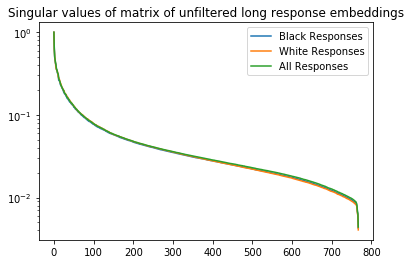

In [6]:
plot_singular_values(
    [embed_black, embed_white, embed],
    "Singular values of matrix of unfiltered long response embeddings",
    ["Black Responses", "White Responses", "All Responses"]
)

## Interpolative decomposition

In [20]:
methods = ["DEIM", "QR", "random"]

# Modified CUR which only selects columns.
# Does not compute the U or R
def cur(A, idx=False, SVD=None, rank=None, p_C=None, method="DEIM"):
    
    if SVD==None:
        SVD = np.linalg.svd(A, full_matrices=False)
    if rank==None:
        rank = np.linalg.matrix_rank(A)
    
    V,S,Wt = SVD
    
    def DEIM(M, rank, p=None):
        if not p:
            p = []
            p.append(np.argmax(np.abs(M[:,0])))
        for i in range(len(p),rank):
            r = M[:,i] - np.dot(M[:,:i],np.dot(np.linalg.inv(M[:,:i][p]), M[:,i][p]))
            p.append(np.argmax(np.abs(r)))
        return p
    
    if method == "DEIM":
        p_C = DEIM(np.transpose(Wt), rank, p_C)
    elif method == "QR":
        p_C = interp_decomp(A.astype(np.float64), rank)[0][:rank]
    elif method == "random":
        p_C = random.sample(range(np.shape(Wt)[1]), rank)
    
    C = A[:,p_C]
    
    return (C,p_C) if idx else C

In [32]:
# Using DEIM
C_black_DEIM, p_C_black_DEIM = cur(embed_black, idx=True, method="DEIM")
C_white_DEIM, p_C_white_DEIM = cur(embed_white, idx=True, method="DEIM")
C_DEIM, p_C_DEIM = cur(embed, idx=True, method="DEIM")

# Using QR
C_black_QR, p_C_black_QR = cur(embed_black, idx=True, method="QR")
C_white_QR, p_C_white_QR = cur(embed_white, idx=True, method="QR")
C_QR, p_C_QR = cur(embed, idx=True, method="QR")

# Using random
C_black_random, p_C_black_random = cur(embed_black, idx=True, method="random")
C_white_random, p_C_white_random = cur(embed_white, idx=True, method="random")
C_random, p_C_random = cur(embed, idx=True, method="random")

## Do any of the interpolative methods show a bias toward responses with more sentences?

In [33]:
def plot_sentence_counts(ax, flat, res, p_C, title):
    found_idx = []
    lengths = []
    for i in p_C[:100]:
        idx = flat[i][0]
        if idx not in found_idx:
            found_idx.append(idx)
            lengths.append(len(nltk.sent_tokenize(res[idx])))
    ax.hist([lengths])
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.yaxis.set_tick_params(labelleft=True)
    ax.set_title(title)

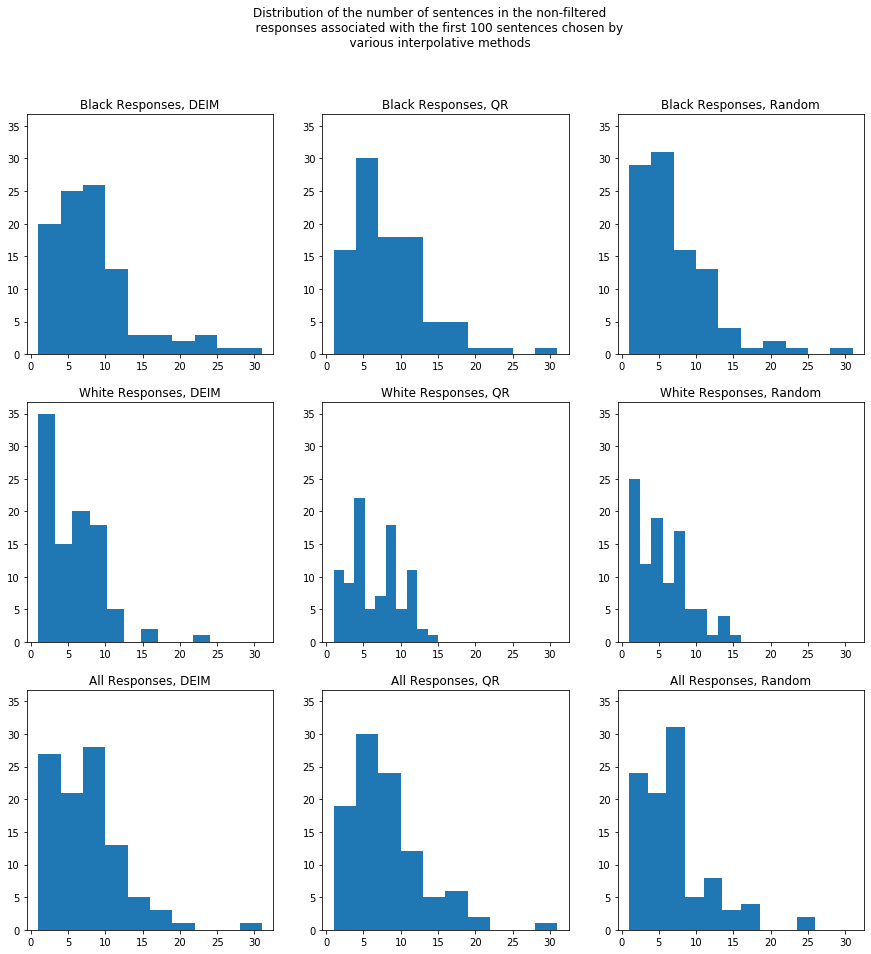

In [34]:
fig, axs = plt.subplots(3,3, sharex=True, sharey=True, figsize=(15,15))
fig.suptitle(
    """Distribution of the number of sentences in the non-filtered 
    responses associated with the first 100 sentences chosen by
    various interpolative methods"""
)

# Black
plot_sentence_counts(axs[0][0], res_black_split_flat, res, p_C_black_DEIM, "Black Responses, DEIM")
plot_sentence_counts(axs[0][1], res_black_split_flat, res, p_C_black_QR, "Black Responses, QR")
plot_sentence_counts(axs[0][2], res_black_split_flat, res, p_C_black_random, "Black Responses, Random")

# White
plot_sentence_counts(axs[1][0], res_white_split_flat, res, p_C_white_DEIM, "White Responses, DEIM")
plot_sentence_counts(axs[1][1], res_white_split_flat, res, p_C_white_QR, "White Responses, QR")
plot_sentence_counts(axs[1][2], res_white_split_flat, res, p_C_white_random, "White Responses, Random")

# All
plot_sentence_counts(axs[2][0], res_split_flat, res, p_C_DEIM, "All Responses, DEIM")
plot_sentence_counts(axs[2][1], res_split_flat, res, p_C_QR, "All Responses, QR")
plot_sentence_counts(axs[2][2], res_split_flat, res, p_C_random, "All Responses, Random")

## Highlight chosen sentences in the responses they appear

In [58]:
skip = []
for i in p_C_DEIM[:100]:
    
    if res_split_flat[i][0] in skip:
        continue
    skip.append(res_split_flat[i][0])
    
    r = res[res_split_flat[i][0]]
    r_split = nltk.sent_tokenize(r)
    race = df['racial_group'].iloc[res_split_flat[i][0]]
    print(colored(race, 'blue', attrs=['bold']))
    
    highlight = []
    for j in p_C_DEIM[:100]:
        if res_split_flat[j][0] == res_split_flat[i][0]:
            highlight.append(res_split_flat[j][1])
    
    for j in range(len(r_split)):
        if j in highlight:
            print(colored(r_split[j], 'red', attrs=['bold']) + " ", end='')
        else:
            print(r_split[j] + " ", end='')
    print("\n")

black
i think that as far as i'm concerned & a good many of us i imagine, if we could get into the part of service we wanted to be in we be much better soldiers then if we did not't like it after we got it, then we would have to govern ourselves accordingly 

black
for that one great cause only. in other words we are fighting for the same thing. the negro are paying for this war as well as the white with their lives and blood. so why not give them an  chance too. i think they have earned it. and i think they will continue to do so until the duration. as lincoln once said all men were created equal. let it  that way. 

black
my home down south really seems to be against the negro, pays little money. they want to beat a negro up. i 9 am talking about the white man; they kill the negro. they look for one man and kill two or three others and nothing he did about it. i am going to do all i can in this army to win this war with god to help, and i am looking for that to be stopped. after the 


black
i would be happier if we had a half a day saturday and all day sunday for recreation. 

black
i like ft. mcclellan and would like to stay here not only because it's near home but also because i like alabama. it's good farming country; good place to raise cattle. 

white
our orientation lectures included this statements. "the doctrine of manifest destiny must be revived in regard to central and south america. poster throughout the camp proclaim "we alone are capable of dictating the terms of a peace these statements seem to me to be the things we are fighting against. why if we are fighting for equal rights for all peoples are we taught these things? 

white
there is to many non-commission officers what don't know their stuff in our outfit. and all they know is what little that is in the book 21-100. and books will not win this war. we have to many young officers that doesn't know what they are doing. we have to many young boys here. and a lot of old men. that could do more out i

In [60]:
skip = []
for i in p_C_QR[:100]:
    
    if res_split_flat[i][0] in skip:
        continue
    skip.append(res_split_flat[i][0])
    
    r = res[res_split_flat[i][0]]
    r_split = nltk.sent_tokenize(r)
    race = df['racial_group'].iloc[res_split_flat[i][0]]
    print(colored(race, 'blue', attrs=['bold']))
    
    highlight = []
    for j in p_C_QR[:100]:
        if res_split_flat[j][0] == res_split_flat[i][0]:
            highlight.append(res_split_flat[j][1])
    
    for j in range(len(r_split)):
        if j in highlight:
            print(colored(r_split[j], 'red', attrs=['bold']) + " ", end='')
        else:
            print(r_split[j] + " ", end='')
    print("\n")

black
perfectly satisfied 

white
we fight for this freedom. we must work and work hard. built more airplanes, tanks, ships and all the other thing we fight together and work together. all the other boys over sea are gave their lives to safe the country 

black
why is it that a soldier can't get a furlough when he wants it without a lots of shit. we have some rotten noncom in our outfit they should be sranfered we don't like them so well. if a man just have to be in this mess they should let him decide where he wants to go. i am not sure. but whoever reads this do you think you would be satisfied if all of your privileges were taken away from you and can't go where you wanted to or stay as long as your wanted to. 

white
it is all pretty covered. the food is poor sometimes & what kind of a deal did that goat ranch make you. & the fishing. there's lots of cattle men in the west. sometimes the boys don't eat because the stomach will not stand - the food. & therefore they eat to much cand

dear sir:  this camp is a good place for basic training because in a long run it will bring the soldier morale down. most of the commissioned officers are not experience to teach anyone combat duties & expect them to go across the water to fight. i would rather be shot here then to go across with some of them. there is a little prejudice here because they will not protected the negro officers. of course some of them dont are not ready for it. it seems as thou they army doesn't have a system to go by. most of the commissioned are to old for the job they have. the still have old ideas. the army of today should be young, fast & streamline. a young man brains work faster that a old person. of have all make this camps training center. i think i could do my bet work training new soldier. i have already trained 3 groups of new soldier & if i must say so myself they are well trained. 

white
i think this outfit should have sat. afternoons off. for games 

black
in regards to transportation (ra

In [61]:
skip = []
for i in p_C_random[:100]:
    
    if res_split_flat[i][0] in skip:
        continue
    skip.append(res_split_flat[i][0])
    
    r = res[res_split_flat[i][0]]
    r_split = nltk.sent_tokenize(r)
    race = df['racial_group'].iloc[res_split_flat[i][0]]
    print(colored(race, 'blue', attrs=['bold']))
    
    highlight = []
    for j in p_C_random[:100]:
        if res_split_flat[j][0] == res_split_flat[i][0]:
            highlight.append(res_split_flat[j][1])
    
    for j in range(len(r_split)):
        if j in highlight:
            print(colored(r_split[j], 'red', attrs=['bold']) + " ", end='')
        else:
            print(r_split[j] + " ", end='')
    print("\n")

black
i have been in the service going on eight months. personally i think that i would have been much further advanced than i am had i been placed in a camp in a northern jurisdiction. our camp is  entirely made up of southern non commissioned officers. i was sent here from my basic camp with four other fellows. my present camp had already been established. the only chance i had to get anywheres was to work my way up. these southerners seem too down a man from the north, why i do not know. it must be jealousy. one reason is the average northern negro has had quite a bit of schooling, which the southern negro has not. it is their inferiority, i think, that causes the main trouble. i have the complete confidence in myself that i could duplicate the job of any non-comm in my company. i have yet to (over ii became a p.f.c. i haven't been given the opportunity too hold such a rating, though i have soldiered and i know it. i don't want you too take this as a beef, because i am a fellow that

## Error plots

In [12]:
def get_error(A, method):
    V,S,Wt = np.linalg.svd(A, full_matrices=False)
    rank = np.linalg.matrix_rank(A)
    print("Rank:", rank)
    
    eta_c = np.zeros(rank)
    norm = np.zeros(rank)
    sig = np.zeros(rank)
    
    p_C_k = [] # track any pre-selected columns
    
    A_k = np.zeros(A.shape)
    for k in range(rank):
        SVD_k = (V[:,:k+1], S[:k+1], Wt[:k+1,:])
        A_k = (SVD_k[0] * SVD_k[1][...,None,:] @ SVD_k[2])
        C_k, p_C_k = cur(A, idx=True, SVD=(V,S,Wt), rank=k+1, p_C=p_C_k, method=method)
        WtF_k = SVD_k[2][:k+1,:][:,p_C_k[:k+1]]        
        eta_c[k] = np.linalg.norm(np.linalg.inv(WtF_k))
        X_k = np.linalg.pinv(C_k) @ A
        norm[k] = np.linalg.norm(A - C_k@X_k)
        sig[k] = np.linalg.norm(A - A_k)
        
        if k%100==0:
            print("Progress:",k,"/",rank)
            
    return eta_c, sig, norm, rank

In [13]:
# https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting
def is_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh

In [14]:
def plot_errors(errors, title):
    fig = plt.figure(figsize=(5*len(methods),10))
    fig.suptitle("Error, "+title)
    
    axs = []
    for i in range(0,len(methods)*2,2):
        sharey = None if i == 0 else axs[0][1]
        axs.append([
            fig.add_subplot(len(methods), 2, i+1),
            fig.add_subplot(len(methods), 2, i+2, sharey=sharey)
        ])
    
    for i in range(len(methods)):
        eta_c, sig, norm, rank = errors[i]
        
        #in_range = eta_c <= max(sig) # filter things that mess up scaling
        #axs[i][0].scatter(np.array(range(rank))[in_range], np.array(eta_c)[in_range])
        axs[i][0].scatter(range(rank), eta_c)
        axs[i][0].scatter(range(rank), norm)
        axs[i][0].scatter(range(1,rank+1), sig)
        axs[i][0].set(xlabel='k')
        axs[i][0].legend(["(eta_c)_k", "|| A - C_k(X_k) ||", "sigma_k"])
        axs[i][0].set_title(methods[i])

        out_range = is_outlier(norm/sig) # filter things that mess up scaling
        #axs[i][1].scatter(range(100), (norm[:100]-sig[:100])/sig[:100])
        axs[i][1].scatter(np.array(range(rank))[~out_range], np.array(norm/sig)[~out_range])
        axs[i][1].set(xlabel='k')
        axs[i][1].legend(["|| A - C_k(X_k) || / sigma_(k+1)"])
        axs[i][1].set_title(methods[i])
    
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

Rank: 768
Progress: 0 / 768
Progress: 100 / 768
Progress: 200 / 768
Progress: 300 / 768
Progress: 400 / 768
Progress: 500 / 768
Progress: 600 / 768
Progress: 700 / 768


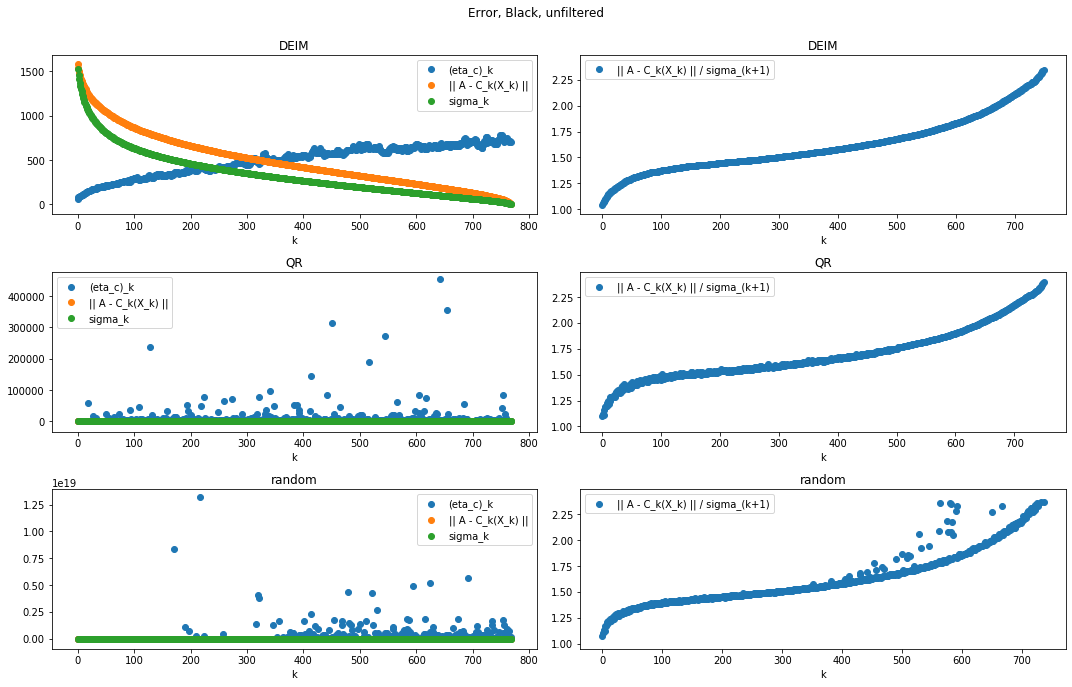

In [35]:
#errors_black = [get_error(embed_black,m) for m in methods]
errors_black[1] = get_error(embed_black,"QR")
plot_errors(errors_black, "Black, unfiltered")

Rank: 768
Progress: 0 / 768
Progress: 100 / 768
Progress: 200 / 768
Progress: 300 / 768
Progress: 400 / 768
Progress: 500 / 768
Progress: 600 / 768
Progress: 700 / 768


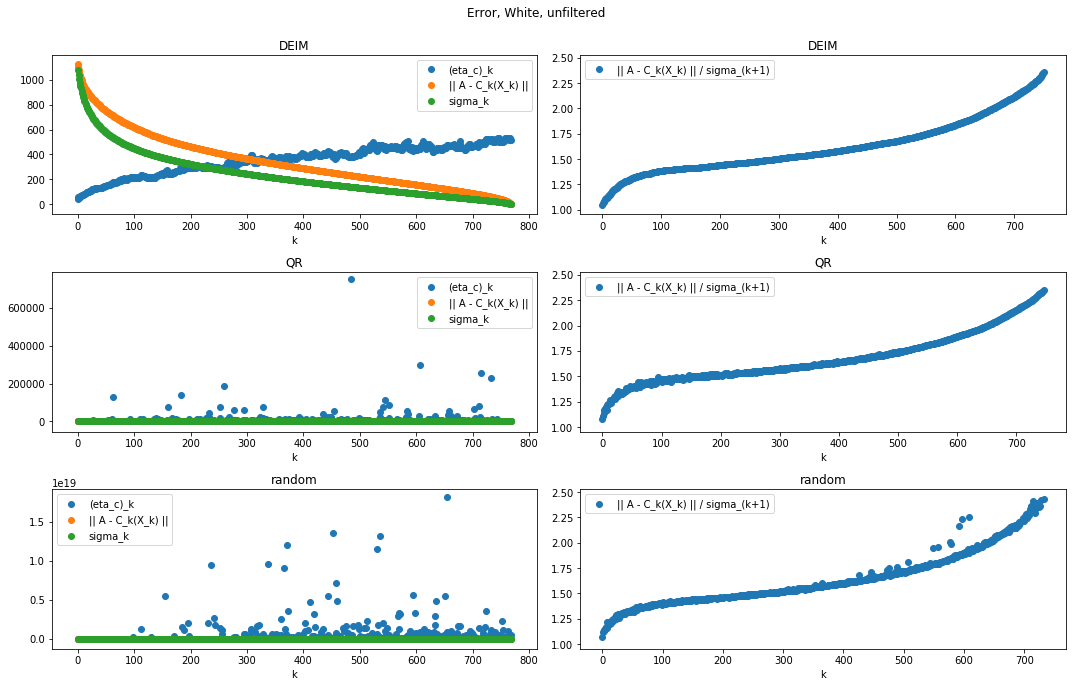

In [36]:
#errors_white = [get_error(embed_white,m) for m in methods]
errors_white[1] = get_error(embed_white,"QR")
plot_errors(errors_white, "White, unfiltered")

Rank: 768
Progress: 0 / 768
Progress: 100 / 768
Progress: 200 / 768
Progress: 300 / 768
Progress: 400 / 768
Progress: 500 / 768
Progress: 600 / 768
Progress: 700 / 768
Rank: 768
Progress: 0 / 768
Progress: 100 / 768
Progress: 200 / 768
Progress: 300 / 768
Progress: 400 / 768
Progress: 500 / 768
Progress: 600 / 768
Progress: 700 / 768
Rank: 768
Progress: 0 / 768
Progress: 100 / 768
Progress: 200 / 768
Progress: 300 / 768
Progress: 400 / 768
Progress: 500 / 768
Progress: 600 / 768
Progress: 700 / 768


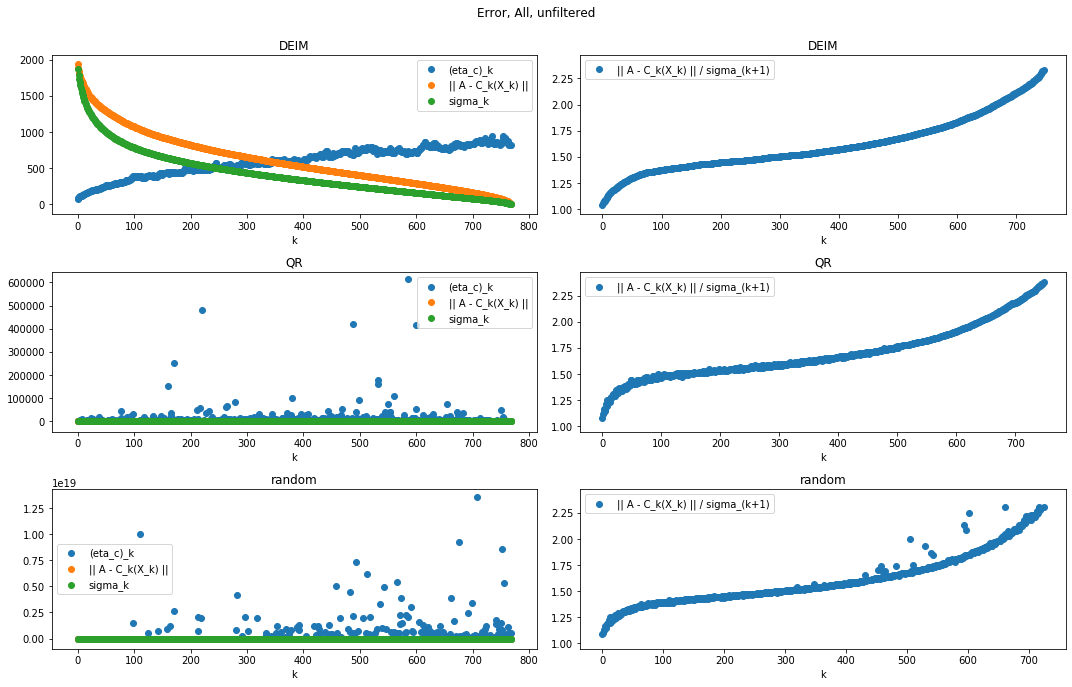

In [38]:
errors = [get_error(embed,m) for m in methods]
plot_errors(errors, "All, unfiltered")

<br><br>

# Look at responses, filtered by discussion of race

In [82]:
df_fil = df[df['about_race'] > 0]
res_black_fil = df_fil[df_fil['racial_group'] == 'black']['long'].tolist()
res_white_fil = df_fil[df_fil['racial_group'] == 'white']['long'].tolist()
res_fil = res_black_fil + res_white_fil

## Embed responses

In [24]:
# Split each response into sentences
res_black_split_fil = [nltk.sent_tokenize(r) for r in res_black_fil]
res_white_split_fil = [nltk.sent_tokenize(r) for r in res_white_fil]

# Flatten, storing original indices
res_black_split_flat_fil = []
for i in range(len(res_black_split_fil)): # Response index
    for j in range(len(res_black_split_fil[i])): # Sentence index within response
        s = res_black_split_fil[i][j]
        res_black_split_flat_fil.append((i,j,s))
        
res_white_split_flat_fil = []
for i in range(len(res_white_split_fil)):
    for j in range(len(res_white_split_fil[i])):
        s = res_white_split_fil[i][j]
        res_white_split_flat_fil.append((i+len(res_black_fil),j,s))
        
res_split_flat_fil = res_black_split_flat_fil + res_white_split_flat_fil

# Embed
embed_black_fil = np.transpose(model.encode([r[2] for r in res_black_split_flat_fil]))
embed_white_fil = np.transpose(model.encode([r[2] for r in res_white_split_flat_fil]))
embed_fil = np.concatenate((embed_black_fil, embed_white_fil), axis=1)

## Plot singular values

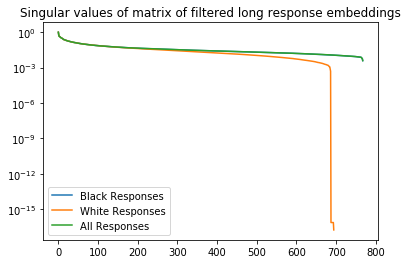

In [25]:
plot_singular_values(
    [embed_black_fil, embed_white_fil, embed_fil],
    "Singular values of matrix of filtered long response embeddings",
    ["Black Responses", "White Responses", "All Responses"]
)

## Interpolative decomposition

In [26]:
# Using DEIM
C_black_DEIM_fil, p_C_black_DEIM_fil = cur(embed_black_fil, idx=True, method="DEIM")
C_white_DEIM_fil, p_C_white_DEIM_fil = cur(embed_white_fil, idx=True, method="DEIM")
C_DEIM_fil, p_C_DEIM_fil = cur(embed_fil, idx=True, method="DEIM")

# Using QR
C_black_QR_fil, p_C_black_QR_fil = cur(embed_black_fil, idx=True, method="QR")
C_white_QR_fil, p_C_white_QR_fil = cur(embed_white_fil, idx=True, method="QR")
C_QR_fil, p_C_QR_fil = cur(embed_fil, idx=True, method="QR")

# Using random
C_black_random_fil, p_C_black_random_fil = cur(embed_black_fil, idx=True, method="random")
C_white_random_fil, p_C_white_random_fil = cur(embed_white_fil, idx=True, method="random")
C_random_fil, p_C_random_fil = cur(embed_fil, idx=True, method="random")

## Do any of the interpolative methods show a bias toward responses with more sentences?

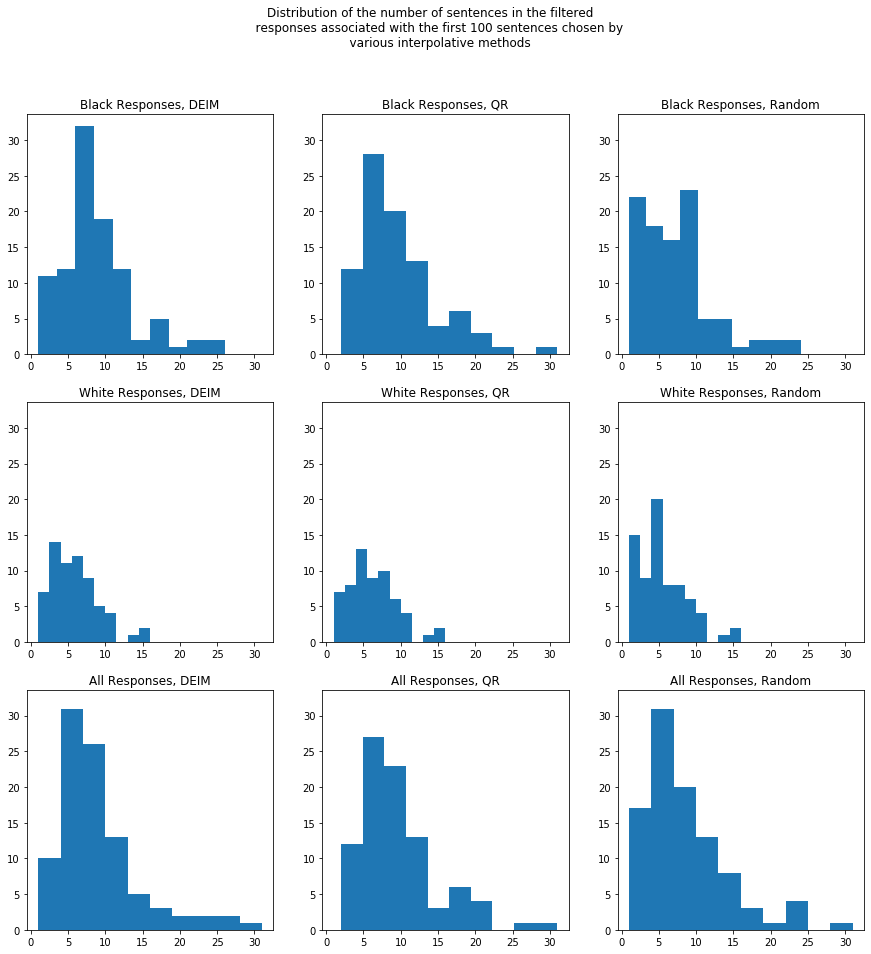

In [27]:
fig, axs = plt.subplots(3,3, sharex=True, sharey=True, figsize=(15,15))
fig.suptitle(
    """Distribution of the number of sentences in the filtered 
    responses associated with the first 100 sentences chosen by
    various interpolative methods"""
)

# Black
plot_sentence_counts(axs[0][0], res_black_split_flat_fil, res_fil, p_C_black_DEIM_fil, "Black Responses, DEIM")
plot_sentence_counts(axs[0][1], res_black_split_flat_fil, res_fil, p_C_black_QR_fil, "Black Responses, QR")
plot_sentence_counts(axs[0][2], res_black_split_flat_fil, res_fil, p_C_black_random_fil, "Black Responses, Random")

# White
plot_sentence_counts(axs[1][0], res_white_split_flat_fil, res_fil, p_C_white_DEIM_fil, "White Responses, DEIM")
plot_sentence_counts(axs[1][1], res_white_split_flat_fil, res_fil, p_C_white_QR_fil, "White Responses, QR")
plot_sentence_counts(axs[1][2], res_white_split_flat_fil, res_fil, p_C_white_random_fil, "White Responses, Random")

# All
plot_sentence_counts(axs[2][0], res_split_flat_fil, res_fil, p_C_DEIM_fil, "All Responses, DEIM")
plot_sentence_counts(axs[2][1], res_split_flat_fil, res_fil, p_C_QR_fil, "All Responses, QR")
plot_sentence_counts(axs[2][2], res_split_flat_fil, res_fil, p_C_random_fil, "All Responses, Random")

## Highlight chosen sentences in the responses they appear

In [84]:
skip = []
for i in p_C_DEIM_fil[:100]:
    
    if res_split_flat_fil[i][0] in skip:
        continue
    skip.append(res_split_flat_fil[i][0])
    
    r = res_fil[res_split_flat_fil[i][0]]
    r_split = nltk.sent_tokenize(r)
    race = df_fil['racial_group'].iloc[res_split_flat_fil[i][0]]
    print(colored(race, 'blue', attrs=['bold']))
    
    highlight = []
    for j in p_C_DEIM_fil[:100]:
        if res_split_flat_fil[j][0] == res_split_flat_fil[i][0]:
            highlight.append(res_split_flat_fil[j][1])
    
    for j in range(len(r_split)):
        if j in highlight:
            print(colored(r_split[j], 'red', attrs=['bold']) + " ", end='')
        else:
            print(r_split[j] + " ", end='')
    print("\n")

white
the above is my honest opinion about the war. as for negro i believe they make good soldiers and will fight ok. but to mingle them with white soldiers is against our ideals and to do so will cause considerable trouble. however i think the war effort is going along good and we will win in the end. 

black
for that one great cause only. in other words we are fighting for the same thing. the negro are paying for this war as well as the white with their lives and blood. so why not give them an  chance too. i think they have earned it. and i think they will continue to do so until the duration. as lincoln once said all men were created equal. let it  that way. 

black
my home down south really seems to be against the negro, pays little money. they want to beat a negro up. i 9 am talking about the white man; they kill the negro. they look for one man and kill two or three others and nothing he did about it. i am going to do all i can in this army to win this war with god to help, and i

we colored soldiers don't have any service club at all. we colored soldiers don't have bus service like we should. have a very hard time leaving and coming to the camp. why don't we have cots to sleep on. and we don't have any costs. we have to sleep on wooden bunks. why not 

black
in reference to question (54) about rights & privledges of negro. i know the negro dont get what he deserves not because he isn't outfit for the job, or whatever it may be it's because his skin is black. in southern camps, the negro do or else. transportation isn't outfit for a dog, in no camp that i've been. it wouldn't make any difference with me and i don't think any other negro about mixing with whites (underlined for emphasis). he doesn't look upon it as being an honor. it's just rights that's due every man, to choose, think & speak, what he thinks (underlined for emphasis). 

black
dear sir:  this camp is a good place for basic training because in a long run it will bring the soldier morale down. most

In [85]:
skip = []
for i in p_C_QR_fil[:100]:
    
    if res_split_flat_fil[i][0] in skip:
        continue
    skip.append(res_split_flat_fil[i][0])
    
    r = res_fil[res_split_flat_fil[i][0]]
    r_split = nltk.sent_tokenize(r)
    race = df_fil['racial_group'].iloc[res_split_flat_fil[i][0]]
    print(colored(race, 'blue', attrs=['bold']))
    
    highlight = []
    for j in p_C_QR_fil[:100]:
        if res_split_flat_fil[j][0] == res_split_flat_fil[i][0]:
            highlight.append(res_split_flat_fil[j][1])
    
    for j in range(len(r_split)):
        if j in highlight:
            print(colored(r_split[j], 'red', attrs=['bold']) + " ", end='')
        else:
            print(r_split[j] + " ", end='')
    print("\n")

black
i believe that southern whites in their stubborn ignorance are doing a great deal to aid the axis. sometimes i really believe they would rather see the allies lose than see the negro gain equal status with them. they dislike the negro‚äîbut when asked why, they fail to give an intelligent answer. they believe that intelligent negro are dangerous, but they tolerate the ignorant ones because they feel as though it is a simple matter to scare him into submission to the whites. this is generally true. the whites fear interracial marriage most. if they did not‚äôt feel their women might mingle with negro, i believe even the intelligent negro would be allowed more opportunity for equal status. i‚äôve wanted to say this for a long time. thank you. 

black
why is it that the officers (white) hate to give negro soldiers furloughs? i have been out here and a long ways from home and haven't had a chance to go home. so many boys i have come out here with have gone home. cant a man fight for 


white
the negro is liked much less below the mason dixon line. i have noticed that the southern people do not get along with them as well as mid. western or northern people. 

black
having travel west to utah and at present in the south. i can't see why the govt. sends negro troops to either place. they fight for freedom but only segregation prevails both through the civilians in towns and cities, as well as through out the training camps. white soldiers have preference on buses, railroads, and if any one most be late for reverllie it is the negro. he is always last when it becomes a question of transportation. it is my belief that negro are treated more fairly in the northern and eastern states. 

black
dear sir:  this camp is a good place for basic training because in a long run it will bring the soldier morale down. most of the commissioned officers are not experience to teach anyone combat duties & expect them to go across the water to fight. i would rather be shot here then to go

In [86]:
skip = []
for i in p_C_random_fil[:100]:
    
    if res_split_flat_fil[i][0] in skip:
        continue
    skip.append(res_split_flat_fil[i][0])
    
    r = res_fil[res_split_flat_fil[i][0]]
    r_split = nltk.sent_tokenize(r)
    race = df_fil['racial_group'].iloc[res_split_flat_fil[i][0]]
    print(colored(race, 'blue', attrs=['bold']))
    
    highlight = []
    for j in p_C_random_fil[:100]:
        if res_split_flat_fil[j][0] == res_split_flat_fil[i][0]:
            highlight.append(res_split_flat_fil[j][1])
    
    for j in range(len(r_split)):
        if j in highlight:
            print(colored(r_split[j], 'red', attrs=['bold']) + " ", end='')
        else:
            print(r_split[j] + " ", end='')
    print("\n")

black
i think if the negro had his full rights choices in the army the man would soon be over. but if the negro dint have his rights and choice in the army it will always be war, such as aviation air plane mechanic certain other things. 

black
we are in a separate outfit thats probably why they don't have separate px and service clubs. i often wonder what will be my reward for fighting in this war. my enthusiasm is not as high as the white boys. they have more to loose or gain. i was refused room in a white hotel when i went to the induction station in los angeles. that did not give me much courage to want to fight. if i thought the white people would give the colored people living a square deal i would gladly die for the cause. but i know they will not. still i think we should iron all that out after the war is over. we have a battle to win. it comes first. i am one who wrote to secretary stimeon about that 

black
 boston 24th avn. sa rd eglin sield, s12.negro have fought and died i

in being in a  camp, white pvt's. wouldn't want negro non comisions officers to give them orders. we doesn't mind fighting, if we get equal rights and privlage just like the whites. in the south a negro have to always go to the back of all hotels but whites goes in negro places anywhere they want to., i feel that is we are going to get equal rights we should get them now. it would make is feel more like we have some thing to fight for. but like it is now. it might turn out just like it did in the other war. after the war less privlages and right than before the war started. they're still whipping colored women on the buses in the south and lynching negro men on suspicion. 

black
my full opinion, is this. i think the white man is no better than the colored, "god" created all, men to be equal. every color man, is looking forward to be treated as such after the war. it should be understood through out this war, that slavery time is over. but some how  the people (white) in the south have

## Error plots

Rank: 768
Progress: 0 / 768
Progress: 100 / 768
Progress: 200 / 768
Progress: 300 / 768
Progress: 400 / 768
Progress: 500 / 768
Progress: 600 / 768
Progress: 700 / 768
Rank: 768
Progress: 0 / 768
Progress: 100 / 768
Progress: 200 / 768
Progress: 300 / 768
Progress: 400 / 768
Progress: 500 / 768
Progress: 600 / 768
Progress: 700 / 768
Rank: 768
Progress: 0 / 768
Progress: 100 / 768
Progress: 200 / 768
Progress: 300 / 768
Progress: 400 / 768
Progress: 500 / 768
Progress: 600 / 768
Progress: 700 / 768
Rank: 768
Progress: 0 / 768
Progress: 100 / 768
Progress: 200 / 768
Progress: 300 / 768
Progress: 400 / 768
Progress: 500 / 768
Progress: 600 / 768
Progress: 700 / 768


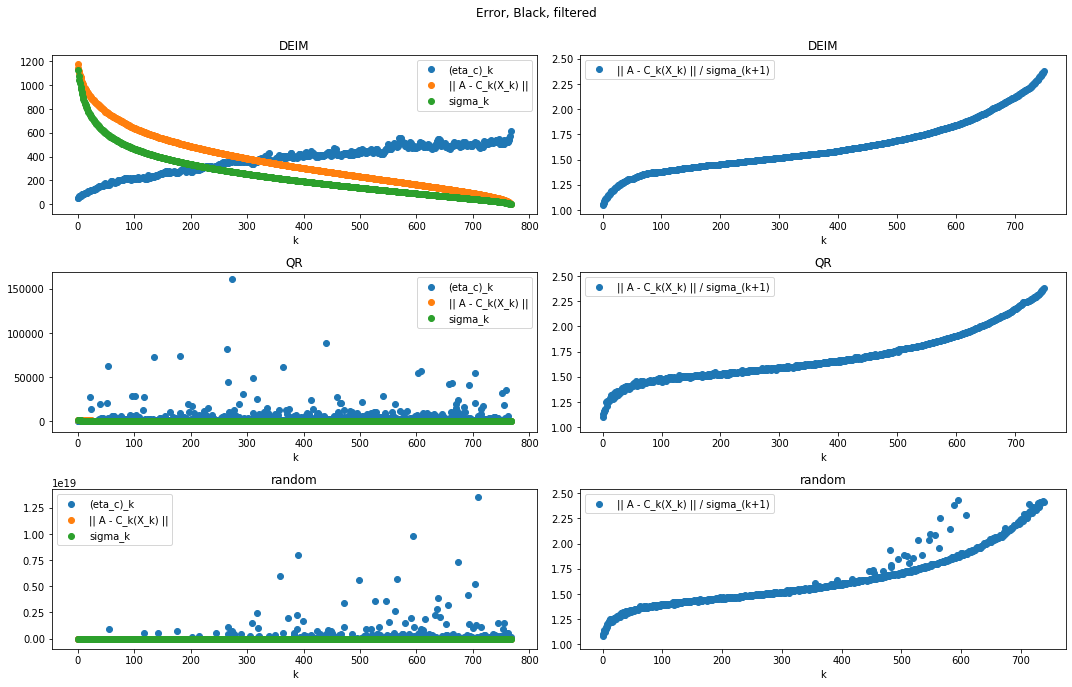

In [29]:
errors_black_fil = [get_error(embed_black_fil,m) for m in methods]
errors_black_fil[1] = get_error(embed_black_fil,"QR")
plot_errors(errors_black_fil, "Black, filtered")

In [30]:
errors_white_fil = [get_error(embed_white_fil,m) for m in methods]
plot_errors(errors_white_fil, "White, filtered")

Rank: 687
Progress: 0 / 687
Progress: 100 / 687
Progress: 200 / 687
Progress: 300 / 687
Progress: 400 / 687
Progress: 500 / 687
Progress: 600 / 687
Rank: 687
Progress: 0 / 687
Progress: 100 / 687
Progress: 200 / 687
Progress: 300 / 687
Progress: 400 / 687
Progress: 500 / 687
Progress: 600 / 687
Rank: 687
Progress: 0 / 687
Progress: 100 / 687
Progress: 200 / 687
Progress: 300 / 687
Progress: 400 / 687


LinAlgError: Singular matrix

Rank: 768
Progress: 0 / 768
Progress: 100 / 768
Progress: 200 / 768
Progress: 300 / 768
Progress: 400 / 768
Progress: 500 / 768
Progress: 600 / 768
Progress: 700 / 768
Rank: 768
Progress: 0 / 768
Progress: 100 / 768
Progress: 200 / 768
Progress: 300 / 768
Progress: 400 / 768
Progress: 500 / 768
Progress: 600 / 768
Progress: 700 / 768
Rank: 768
Progress: 0 / 768
Progress: 100 / 768
Progress: 200 / 768
Progress: 300 / 768
Progress: 400 / 768
Progress: 500 / 768
Progress: 600 / 768
Progress: 700 / 768


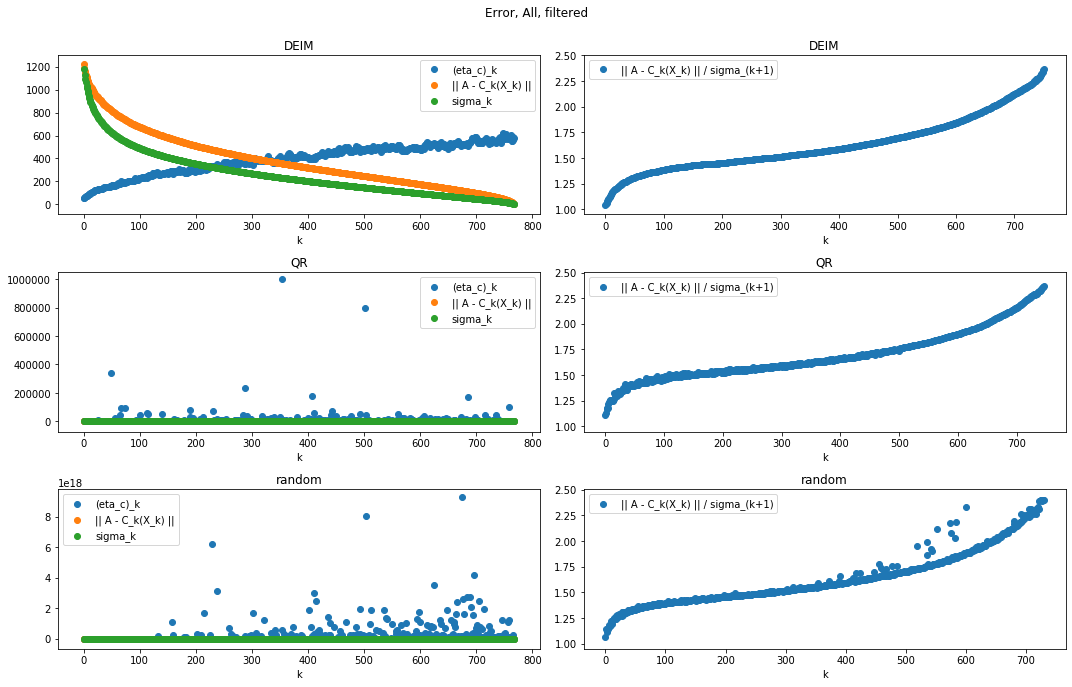

In [31]:
errors_fil = [get_error(embed_fil,m) for m in methods]
plot_errors(errors_fil, "All, filtered")